In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from my_functions import *

In [360]:
houses_train_cleaned = pd.read_csv('../datasets/cleaned/house_train_cleaned.csv')
houses_test_cleaned = pd.read_csv('../datasets/cleaned/house_test_cleaned.csv')

In [361]:
# random_feature_thresh_test(houses_train_cleaned, 'SalePrice', features_all, 1.5)

In [362]:
# # mean_corr = houses_train_cleaned.corr()['SalePrice'].mean()
features = get_features(houses_train_cleaned, 0) # I want as many features as possible for LassoCV, so I'm passing a threshold of 0
len(features)


235

In [363]:
X_real_test = houses_test_cleaned[[col for col in features if col in houses_test_cleaned]]
X_real_test.shape

(878, 214)

## Prepping model for Kaggle Submission

In [364]:
# Garage Cars was type int64 in houses_test_cleaned, was type float in houses_train_cleaned_pol_scale
houses_test_cleaned['Garage Cars'] = houses_test_cleaned['Garage Cars'].apply(lambda x: float(x))

In [365]:
houses_test_cleaned.shape

(878, 263)

## Testing!!

### Selecting X and Y

In [366]:
outlier_indices = [1796, 125] # These indices were throwing off my model drastically
X = houses_train_cleaned[[col for col in features if col in houses_test_cleaned]].drop(outlier_indices)
y = houses_train_cleaned['SalePrice'].drop(outlier_indices)

In [367]:
# Establishing OLS model to be able to select P-Values
model = sm.OLS(y, X).fit()

In [368]:
# Selecting features by p-value. Intentionally trying to overfit this model to let LassoCV do its work
significant_features = list(model.pvalues[model.pvalues < .45].index) # Thanks foxyblue from Stack Overflow! https://stackoverflow.com/questions/37508158/how-to-extract-a-particular-value-from-the-ols-summary-in-pandas/41212509

In [369]:
X = houses_train_cleaned[[col for col in significant_features if col in houses_test_cleaned]].drop(outlier_indices)

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=342)

In [371]:
# Scaling my data for Ridge
sc = StandardScaler()

In [372]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Training model on all data

In [373]:
lr = LinearRegression()

In [374]:
lr.fit(X, y)

LinearRegression()

In [375]:
X_real_test = houses_test_cleaned[[col for col in significant_features if col in houses_test_cleaned]]
X_real_test.shape

(878, 152)

In [376]:
X_real_test_sc = sc.fit_transform(X_real_test)

In [377]:
len(X_real_test)

878

In [378]:
# From Lesson 4.02 on Logistic Regression! Thanks Adi Brohnstein

l_alphas = np.logspace(0, 5, 500)
# Cross-validate over our list of lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train);

In [379]:
y_pred = lasso_cv.predict(X_test_sc)

In [380]:
lasso_cv.score(X_test_sc, y_test)

0.9441565421717778

In [381]:
print(f'The MSE is {metrics.mean_squared_error(y_test, y_pred, squared=False)}')

The MSE is 18867.961665942403


In [382]:
# Baseline Model
null_pred = np.zeros_like(y_test)
null_pred = null_pred + y_test.mean()
print(f'The Baseline RMSE is {metrics.mean_squared_error(y_test, null_pred, squared=False)}')

The Baseline RMSE is 79843.36540784538


## The Model is drastically outperforming the Baseline!

In [383]:
resids = y_test - y_pred

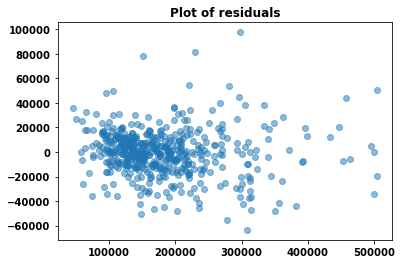

In [384]:
plt.scatter(y_pred, resids, alpha=0.5)
plt.title('Plot of residuals');

This residual plot looks similar to the others, still not doing a great job predicting homes over 220k

In [385]:
houses_test_cleaned['SalePrice'] = lasso_cv.predict(X_real_test_sc)

submission = houses_test_cleaned[['Id', 'SalePrice']]
submission[submission['SalePrice'] < 0]
submission.describe()

,Id,SalePrice
count,878.000000,878.000000
mean,1444.749431,181538.850717
std,850.838263,76739.241219
min,2.000000,34764.840636
25%,692.250000,130836.247954
50%,1433.000000,163069.815449
75%,2197.500000,216034.268894
max,2928.000000,670360.805632


In [386]:
submission.to_csv('../submissions/test52_lasso.csv', index=False)